In this hello-world tutorial we prepare a paradigmatic example for a multi-qubit entangled state, the so-called [GHZ state](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) (named after the three physicists Greenberger, Horne and Zeilinger). The GHZ state is extremely non-classical, and therefore very sensitive to decoherence. Therefore, it is often used as a performance benchmark for today's hardware. Moreover, in many quantum information protocols it is used as a resource for quantum error correction, quantum communication and quantum metrology. 

For classical backends, we can run our circuit on a local simulator or a cloud-based managed simulator. As shown below, one can seamlessly swap between different backends without any modifications to the circuit definition, by just re-defining the device object.

In [1]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

# AWS imports: Import Braket SDK modules
import boto3
from braket.circuits import Circuit, Gate
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsSession

__NOTE__: Please enter your desired S3 location (bucket and key) below.

In [2]:
# Set up S3 bucket (where results are stored). Change the bucket_name to the S3 bucket you created.
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
my_bucket = f"braket-output-{aws_account_id}" # the name of the bucket
my_prefix = "simulation-output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

### Problem: Prepare GHZ State

Goal: Prepare $N$-qubit GHZ state (important for many QIP and sensing protocols): 
$$\left|0,0, ...\right> \rightarrow \left|\mathrm{GHZ}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0, ...\right> + \left|1,1, ...\right>\right).$$

The GHZ state is a quantum superposition of all subsystems being in state 0 with all of them being in state 1 (as often discussed in the famous Gedanken experiment of a cat being dead and alive at the same time). The GHZ state is a maximally entangled quantum state. 

To prepare this state , we build and run the following circuit using a single-qubit Hadamard gate (denoted as H) acting on the first qubit followed by a series of two-qubit CNOT gates: 

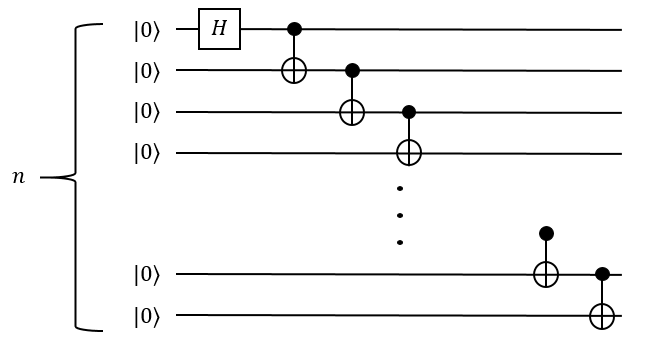

### Setup Circuit

In [3]:
# function to build GHZ state
def ghz_circuit(n_qubits):
    """
    function to return GHZ circuit ansatz
    input: number of qubits
    """

    # instantiate circuit object
    circuit = Circuit()
    
    # add Hadamard gate on first qubit
    circuit.h(0)

    # apply series of CNOT gates
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)

    return circuit

In [4]:
# define circuit
n_qubits = 10
ghz = ghz_circuit(n_qubits)

In [5]:
# print circuit
print(ghz)

T  : |0|1|2|3|4|5|6|7|8|9|
                          
q0 : -H-C-----------------
        |                 
q1 : ---X-C---------------
          |               
q2 : -----X-C-------------
            |             
q3 : -------X-C-----------
              |           
q4 : ---------X-C---------
                |         
q5 : -----------X-C-------
                  |       
q6 : -------------X-C-----
                    |     
q7 : ---------------X-C---
                      |   
q8 : -----------------X-C-
                        | 
q9 : -------------------X-

T  : |0|1|2|3|4|5|6|7|8|9|


### Local Simulator

First we run our circuit locally, using the local simulator.

In [6]:
# set up backend: Local Simulator
device = LocalSimulator()

In [7]:
# run circuit
result = device.run(ghz, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'0000000000': 504, '1111111111': 496})


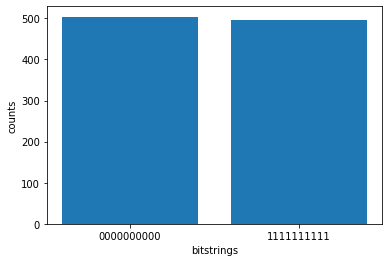

In [8]:
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

As opposed to quantum hardware, where we can only access measurement shots, with a classical simulator we can access the full statevector and amplitudes by assigning the corresponding result types. To do so, we need to append the result types to the circuit before submitting it to run. This can be very useful for debugging.

In [9]:
# the state we want to check its amplitude
bitstring = '0'*n_qubits
# append the result types to the circuit
circuit = ghz.state_vector().amplitude(state=[bitstring]) 
result = device.run(circuit, shots=0).result()
print('The full state vector is:', result.values[0])
print('Amplitude value from state vector for bitstring {} is: {}'.format(bitstring, result.values[1]))

The full state vector is: [0.70710678+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
 0.        +0.j 0.70710678+0.j]
Amplitude value from state vector for bitstring 0000000000 is: {'0000000000': (0.7071067811865475+0j)}


### The Cloud-Based Managed Simulator

As opposed to the local simulator above, we can also run our circuit on a cloud-based simulator. This approach adds some latency overhead, but is beneficial for larger circuits by leveraging the optimized cloud hardware infrastructure. Moreover, all your results will be stored reliably in S3. Here, as part of the API call with ```run()``` you need to supply a S3 location where the metadata and results asscociated with this circuit execution will be stored.

In [10]:
# set up backend
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [11]:
# define larger GHZ circuit
n_qubits = 15
ghz = ghz_circuit(n_qubits)

In [12]:
# run GHZ circuit on cloud simulator
result = device.run(ghz, s3_folder, shots=1000, poll_timeout_seconds=24*60*60).result()
counts = result.measurement_counts
print(counts)

Counter({'111111111111111': 536, '000000000000000': 464})


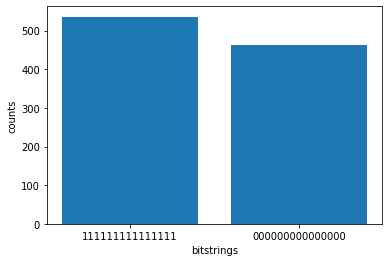

In [13]:
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [14]:
# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['0'*n_qubits])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['1'*n_qubits])

Counts for all-zero bitstring: 464
Counts for all-one bitstring: 536


__NOTE__: Use unique task ID to look up task details in AWS console.

In [15]:
# print unique TASK ID (task = execution of individual circuit)
task_id = result.task_metadata.id
# recover other metadata information such as number of qubits
n = result.task_metadata.deviceParameters['gateModelParameters']['qubitCount']
print('Task ID:', task_id)
print('Number of qubits:', n)

Task ID: arn:aws:braket:us-west-2:875981177017:quantum-task/273a14c0-fb18-4bdf-8637-2577015af8a3
Number of qubits: 15
